In [7]:
%matplotlib inline
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from geom import make_tx_rx_trajectory, plot_radar_trajectory_and_object
from terrain_sim import TerrainSimulator
from sar_sim import SARSimulator
from bp_gpu import BackprojectionGPU
# from rcs_weight import make_W_of_theta  # 필요 시
# import ipywidgets as widgets
# display(widgets.IntSlider())

def hann_window(n):
    return 0.5 - 0.5 * np.cos(2*np.pi*np.arange(n) / (n-1))

def range_compress_from_freq(s_freq, apply_window=True, use_shift=True):
    x = s_freq.copy()
    if apply_window:
        w = hann_window(x.shape[1])
        x *= w[None, :]
    if (use_shift):
        rc = np.fft.ifft(np.fft.ifftshift(x, axes=1), axis=1)
    else:
        rc = np.fft.ifft(x, axis=1)
    return rc

def db10(x, eps=1e-30):
    return 10.0 * np.log10(np.maximum(x, eps))


In [8]:

sar = SARSimulator(
    f0=100e9, bandwidth=800e6, n_freq=512,
    roughness_obj=0.04,
    k_spec_obj=3.0, k_diff_obj=0.10,
    k_spec_ter=0.02, k_diff_ter=0.05,   # terrain을 더 diffuse하게 -> clutter 강화
    chunk_facets=50000,
    use_cupy=True
)

In [9]:
z0_offset = 20.0
# object_mesh = [(0.0, 0.0, z0_offset), (0, 50.0, z0_offset), (0, -50.0, z0_offset)]
object_mesh = [(0.0, 0.0, z0_offset)]

In [32]:
# 5) 궤적
n_pulses = 1000
tx_traj, rx_traj = make_tx_rx_trajectory(
    n_pulses=n_pulses,
    radius=500.0, z=100.0,
    start_deg=-3.0, end_deg=3.0,
    # start_deg=0.0, end_deg=0.0,
    bistatic=False
)

# (선택) W(theta)
W = None
# theta_samples = np.arange(0, 361, 1)
# rcs_dbsm = ...  # 0~360 배열
# W = make_W_of_theta(theta_samples, rcs_dbsm)

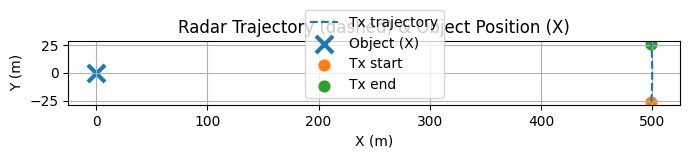

In [33]:

plot_radar_trajectory_and_object(
    object_xyz=object_mesh,
    tx_traj=tx_traj, rx_traj=rx_traj,
    bistatic=False,          # True로 바꾸면 Tx/Rx 둘 다 점선 표시
)

In [37]:
# 6) raw data 취득 (object hybrid, terrain fast)
s_freq, freqs, Rref = sar.generate_phase_history_points(
    centers=object_mesh, amp=None, tx_traj=tx_traj, rx_traj=rx_traj
)

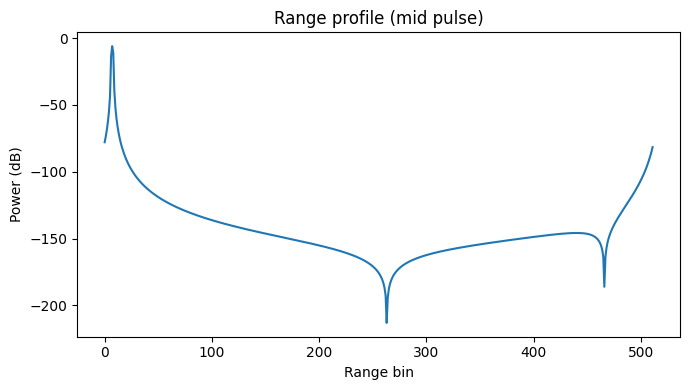

In [36]:
# 7) range compression
rc = range_compress_from_freq(s_freq, apply_window=True)
plt.figure(figsize=(7,4))
plt.plot(db10(np.abs(rc[n_pulses//2])**2))
plt.title("Range profile (mid pulse)")
plt.xlabel("Range bin")
plt.ylabel("Power (dB)")
plt.tight_layout()
plt.show()

[BP-ref] pulse 1/1000
[BP-ref] pulse 101/1000
[BP-ref] pulse 201/1000
[BP-ref] pulse 301/1000
[BP-ref] pulse 401/1000
[BP-ref] pulse 501/1000
[BP-ref] pulse 601/1000
[BP-ref] pulse 701/1000
[BP-ref] pulse 801/1000
[BP-ref] pulse 901/1000


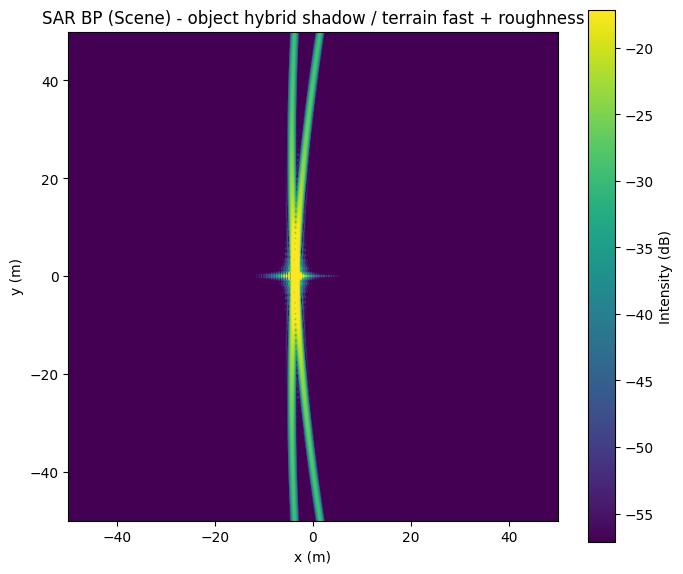

In [ ]:
# 8) BP (GPU streaming)
bp = BackprojectionGPU(use_cupy=True, chunk_pixels=10000)
x_grid = np.linspace(-50, 50, 601)
y_grid = np.linspace(-50, 50, 601)

rc, rwin = sar.range_compress(s_freq=s_freq, frequency=freqs, fft_length=None, window="hanning")

img = bp.bp_2d_rangeprofile_streaming(
    rc=rc,
    range_window=rwin,
    tx_traj=tx_traj,
    rx_traj=rx_traj,
    Rref=Rref,
    x_grid=x_grid,
    y_grid=y_grid,
    z0=0,                # ★ object 높이에 맞추면 훨씬 잘 보임
    f_start=freqs[0],          # ★ start_frequency
    bistatic=True          # monostatic이면 True여도 동일(=0.5*(Rtx+Rrx)=Rtx)
)
# img_mag = np.abs(img)
# img_db = db10(np.abs(img)**2)
img_db = 10*np.log10(np.abs(img)**2 + 1e-30)
vmax = np.percentile(img_db, 99.7)
plt.figure(figsize=(7,6))
plt.imshow(img_db, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
            origin="lower", aspect="equal")#, vmin=vmax-40, vmax=vmax)
plt.colorbar(label="Intensity (dB)")
plt.title("SAR BP (Scene) - object hybrid shadow / terrain fast + roughness")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.tight_layout()
plt.show()

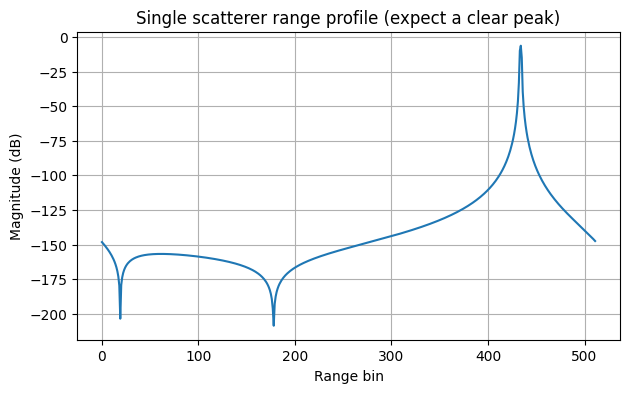

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sar_sim import SARSimulator, C0
from geom import make_tx_rx_trajectory  # 당신 코드에 맞게 경로 조정

def range_compress_baseband(s_freq):
    w = np.hanning(s_freq.shape[1])
    x = s_freq * w[None, :]
    rc = np.fft.ifft(x, axis=1)
    return rc

sar = SARSimulator(f0=10e9, bandwidth=300e6, n_freq=512, use_baseband=True, use_cupy=False)

# 1 pulse 모노
tx_traj, rx_traj = make_tx_rx_trajectory(
    n_pulses=1, radius=2500.0, z=2500.0, start_deg=0.0, end_deg=0.0, bistatic=False
)

# 단일 산란점: 원점
centers = np.array([[0.0, 0.0, 0.0]])
amp = np.array([1.0 + 0j])

s_freq, f = sar.generate_phase_history_points(
    centers=centers, amp=amp,
    tx_traj=tx_traj, rx_traj=rx_traj,
    baseband=True
)

rc = range_compress_baseband(s_freq)
profile_db = 20*np.log10(np.abs(rc[0]) + 1e-12)

plt.figure(figsize=(7,4))
plt.plot(profile_db)
plt.title("Single scatterer range profile (expect a clear peak)")
plt.xlabel("Range bin")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.show()

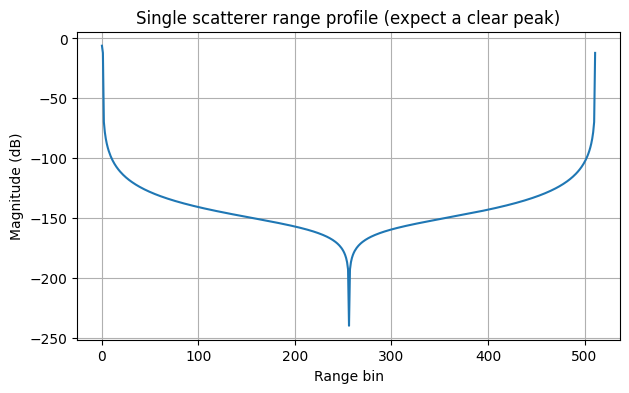

In [ ]:

w = np.hanning(len(f))[None, :]
R0 = np.linalg.norm(centers[0] - tx_traj[0]) + np.linalg.norm(centers[0] - rx_traj[0])
tau0 = R0 / C0
s_comp = s_freq * np.exp(+1j * 2*np.pi * f[None, :] * tau0)
rc1 = np.fft.ifft(np.fft.ifftshift(s_comp * w, axes=1), axis=1)
profile_db = 20*np.log10(np.abs(rc1[0]) + 1e-12)

plt.figure(figsize=(7,4))
plt.plot(profile_db)
plt.title("Single scatterer range profile (expect a clear peak)")
plt.xlabel("Range bin")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'phase vs freq index after compensation')

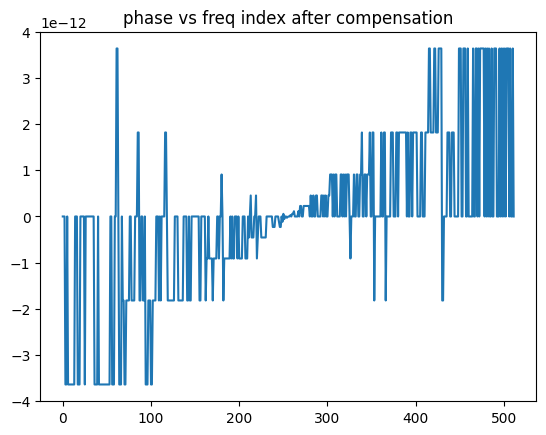

In [ ]:
phi = np.unwrap(np.angle(s_comp[0]))
plt.plot(phi); plt.title("phase vs freq index after compensation")

[1.00000000e+10 1.00005871e+10 1.00011742e+10 1.00017613e+10
 1.00023483e+10 1.00029354e+10 1.00035225e+10 1.00041096e+10
 1.00046967e+10 1.00052838e+10 1.00058708e+10 1.00064579e+10
 1.00070450e+10 1.00076321e+10 1.00082192e+10 1.00088063e+10
 1.00093933e+10 1.00099804e+10 1.00105675e+10 1.00111546e+10
 1.00117417e+10 1.00123288e+10 1.00129159e+10 1.00135029e+10
 1.00140900e+10 1.00146771e+10 1.00152642e+10 1.00158513e+10
 1.00164384e+10 1.00170254e+10 1.00176125e+10 1.00181996e+10
 1.00187867e+10 1.00193738e+10 1.00199609e+10 1.00205479e+10
 1.00211350e+10 1.00217221e+10 1.00223092e+10 1.00228963e+10
 1.00234834e+10 1.00240705e+10 1.00246575e+10 1.00252446e+10
 1.00258317e+10 1.00264188e+10 1.00270059e+10 1.00275930e+10
 1.00281800e+10 1.00287671e+10 1.00293542e+10 1.00299413e+10
 1.00305284e+10 1.00311155e+10 1.00317025e+10 1.00322896e+10
 1.00328767e+10 1.00334638e+10 1.00340509e+10 1.00346380e+10
 1.00352250e+10 1.00358121e+10 1.00363992e+10 1.00369863e+10
 1.00375734e+10 1.003816

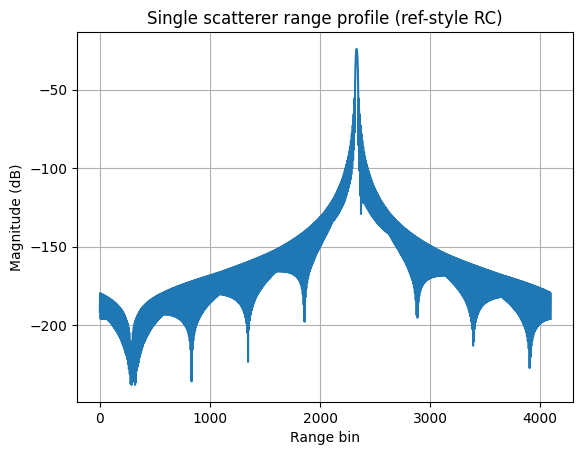

In [ ]:
from sar_sim import SARSimulator
import numpy as np
from geom import make_tx_rx_trajectory, plot_radar_trajectory_and_object
sar = SARSimulator(f0=10e9, bandwidth=300e6, n_freq=512, use_baseband=True, use_cupy=False)
# 단일 점
centers = np.array([[0.0, 0.0, 0.0]])
rcs = np.array([1.0])  # 참고 코드처럼 rcs를 직접 사용

tx_traj, rx_traj = make_tx_rx_trajectory(
    n_pulses=1, radius=2500.0, z=2500.0, start_deg=0.0, end_deg=0.0, bistatic=False
)
s_freq, f, Rref = sar.generate_phase_history_points(
    centers=centers,
    rcs=rcs,
    tx_traj=tx_traj,
    rx_traj=rx_traj,
    range_center=1000.0,      # 또는 None(자동)
    use_farfield=False
)

rc, rwin = sar.range_compress(s_freq, f, fft_length=None, window="Hanning")

import matplotlib.pyplot as plt
plt.plot(20*np.log10(np.abs(rc[0]) + 1e-12))
plt.title("Single scatterer range profile (ref-style RC)")
plt.xlabel("Range bin")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.show()


587084.148727417
[BP-ref] pulse 1/1
(601, 601)


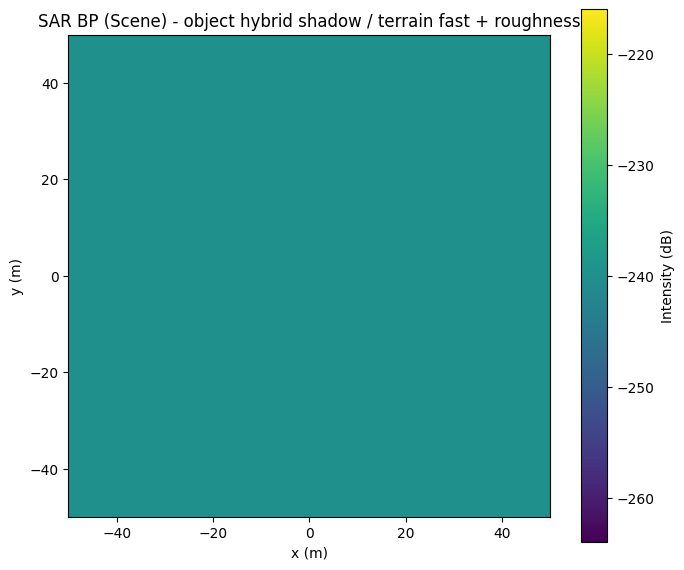

In [ ]:
from bp_gpu import BackprojectionGPU

# 3) BP (reference-style: interp + carrier term)
bp = BackprojectionGPU(use_cupy=True, chunk_pixels=250000)

x_grid = np.linspace(-50, 50, 601)
y_grid = np.linspace(-50, 50, 601)
img = bp.bp_2d_rangeprofile_streaming(
    rc=rc,
    range_window=rwin,
    tx_traj=tx_traj,
    rx_traj=rx_traj,
    Rref=Rref,
    x_grid=x_grid,
    y_grid=y_grid,
    z0=0,                # ★ object 높이에 맞추면 훨씬 잘 보임
    f_start=f[0],          # ★ start_frequency
    bistatic=True          # monostatic이면 True여도 동일(=0.5*(Rtx+Rrx)=Rtx)
)
img_mag = np.abs(img)
img_db = 20 * np.log10(img_mag / (img_mag.max() + 1e-12) + 1e-12)
print(img_db.shape)

plt.figure(figsize=(7,6))
plt.imshow(img_db, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
            origin="lower", aspect="equal")#, vmin=vmax-40, vmax=vmax)
plt.colorbar(label="Intensity (dB)")
plt.title("SAR BP (Scene) - object hybrid shadow / terrain fast + roughness")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.tight_layout()
plt.show()